In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# 1. DATA LOADING
df_majorities = pd.read_csv('data/results_majorities.csv')
df_fdm = pd.read_csv('data/results_fdm.csv')
df_baseline = pd.read_csv('data/results_baseline.csv')

# 2. PREPROCESSING & NORMALIZATION
pd.set_option('display.max_rows', 100)

def compute_match(df, col_a, col_b):
    return df[col_a].astype(str) == df[col_b].astype(str)

df_baseline["match"] = compute_match(df_baseline, "final_answer_norm", "golden_answer_norm")
df_fdm["match"] = compute_match(df_fdm, "final_answer_norm", "golden_answer_norm")
df_majorities["match"] = compute_match(df_majorities, "majority_rand", "golden_answer_norm")

# Filtering for specific framework
df_fdm = df_fdm[df_fdm["desc_framework"] == "no-description"]
df_majorities = df_majorities[df_majorities["desc_framework"] == "no-description"]

# 3. UNIQUE IDENTIFIER CREATION
def make_qid(df):
    return (
        df["dataset"].astype(str) + "_" + 
        df["model"].astype(str) + "_q" + 
        df["query_idx"].astype(str)
    )

for df in [df_baseline, df_fdm, df_majorities]:
    df["qid"] = make_qid(df)

# 4. DATA RESTRUCTURING (Long Format)
cols = ["dataset", "model", "qid", "match"]
df_baseline_long = df_baseline[cols].copy().assign(strategy="Baseline")
df_fdm_long = df_fdm[cols].copy().assign(strategy="PoE (FDM)")
df_mv_long = df_majorities[cols].copy().assign(strategy="PoE (MV)")

df_all = pd.concat([df_baseline_long, df_mv_long, df_fdm_long], ignore_index=True)

# 5. AGGREGATE ACCURACY CALCULATION
df_grouped_accuracy = (
    df_all
    .groupby(["dataset", "model", "strategy"])
    .agg(accuracy=("match", "mean"))
    .reset_index()
)

table_accuracy = (
    df_grouped_accuracy
    .pivot(index=["dataset", "model"], columns="strategy", values="accuracy")
    .reset_index()
)

# Convert to percentage
for col in ["Baseline", "PoE (FDM)", "PoE (MV)"]:
    table_accuracy[col] = (table_accuracy[col] * 100).round(2)

# 6. STATISTICAL SIGNIFICANCE (McNemar)
df_pair = (
    df_all[df_all["strategy"].isin(["PoE (MV)", "PoE (FDM)"])]
    .pivot(index=["dataset", "model", "qid"], columns="strategy", values="match")
    .dropna()
)

sig_results = {}
for keys, df_m in df_pair.groupby(level=[0, 1]):
    mv, fdm = df_m["PoE (MV)"], df_m["PoE (FDM)"]
    n10 = ((mv == 1) & (fdm == 0)).sum()
    n01 = ((mv == 0) & (fdm == 1)).sum()
    
    # Use exact=True for smaller sample sizes
    test = mcnemar([[0, n10], [n01, 0]], exact=True)
    sig_results[keys] = test.pvalue

# 7. LATEX TABLE GENERATION
latex_lines = [
    r"\begin{table}[htbp]", r"\centering",
    r"\begin{tabular}{llcccc}", r"\toprule",
    r"Dataset & Model & Baseline & PoE (MV) & PoE (FDM) & Sig. \\", r"\midrule"
]

table_accuracy = table_accuracy.sort_values(["dataset", "model"])
last_dataset = None

for _, row in table_accuracy.iterrows():
    d_raw, m_raw = row['dataset'], row['model']
    d_clean, m_clean = d_raw.replace("_", r"\_"), m_raw.replace("_", r"\_")
    
    # Grouping visual aid
    d_display = d_clean if d_clean != last_dataset else ""
    last_dataset = d_clean

    mv_val, fdm_val = row['PoE (MV)'], row['PoE (FDM)']
    p_val = sig_results.get((d_raw, m_raw), 1.0)
    
    # Bold winner
    if mv_val > fdm_val:
        mv_s, fdm_s = f"\\textbf{{{mv_val:.2f}}}", f"{fdm_val:.2f}"
    elif fdm_val > mv_val:
        mv_s, fdm_s = f"{mv_val:.2f}", f"\\textbf{{{fdm_val:.2f}}}"
    else:
        mv_s, fdm_s = f"{mv_val:.2f}", f"{fdm_val:.2f}"
        
    sig = r"$\checkmark$" if p_val < 0.05 else ""
    latex_lines.append(f"{d_display} & {m_clean} & {row['Baseline']:.2f} & {mv_s} & {fdm_s} & {sig} \\\\")

latex_lines.extend([r"\bottomrule", r"\end{tabular}", r"\caption{Accuracy and McNemar Significance (MV vs FDM).}", r"\end{table}"])

print("\n".join(latex_lines))

\begin{table}[htbp]
\centering
\begin{tabular}{llcccc}
\toprule
Dataset & Model & Baseline & PoE (MV) & PoE (FDM) & Sig. \\
\midrule
CommonsenseQA & gemma-3-12b-it & 83.00 & 88.00 & 88.00 &  \\
 & gemma-3-27b-it & 0.00 & 86.00 & 86.00 &  \\
 & gemma-3-4b-it & 59.00 & \textbf{78.00} & 77.00 &  \\
 & llama-3.1-8b-instruct & 46.00 & 72.00 & \textbf{79.00} & $\checkmark$ \\
 & llama-3.2-3b-instruct & 32.00 & \textbf{62.00} & 61.00 &  \\
 & llama-3.3-70b-instruct & 29.00 & 88.00 & \textbf{90.00} &  \\
 & llama-4-scout & 2.00 & 89.00 & 89.00 &  \\
 & mistral-nemo & 70.00 & 79.00 & 79.00 &  \\
 & nova-micro-v1 & 0.00 & 84.00 & \textbf{86.00} &  \\
SocialQA & gemma-3-12b-it & 77.00 & 76.00 & 76.00 &  \\
 & gemma-3-27b-it & 20.00 & \textbf{77.00} & 76.00 &  \\
 & gemma-3-4b-it & 60.00 & \textbf{67.00} & 60.00 & $\checkmark$ \\
 & llama-3.1-8b-instruct & 9.00 & \textbf{79.00} & 75.00 &  \\
 & llama-3.2-3b-instruct & 1.00 & 59.00 & \textbf{61.00} &  \\
 & llama-3.3-70b-instruct & 19.00 & 79.00 & 

In [3]:
import pandas as pd
import numpy as np

df_majorities = pd.read_csv('data/results_majorities.csv')
df_fdm = pd.read_csv('data/results_fdm.csv')
df_baseline = pd.read_csv('data/results_baseline.csv')

In [4]:
import pandas as pd

# This will remove the limit on the number of rows displayed
pd.set_option('display.max_rows', None)

# To ensure columns aren't truncated either (optional)
pd.set_option('display.max_columns', None)

In [5]:
df_baseline["match"] = (
        df_baseline["final_answer_norm"].astype(str)
         == df_baseline["golden_answer_norm"].astype(str)
    )

df_fdm["match"] = (
        df_fdm["final_answer_norm"].astype(str)
         == df_fdm["golden_answer_norm"].astype(str)
    )

df_majorities["match"] = (
        df_majorities["majority_rand"].astype(str)
         == df_majorities["golden_answer_norm"].astype(str)
    )

In [6]:
df_fdm = df_fdm[df_fdm["desc_framework"] == "no-description"]
df_majorities = df_majorities[df_majorities["desc_framework"] == "no-description"]

In [7]:
def make_qid(df):
    return (
        df["dataset"].astype(str)
        + "_"
        + df["model"].astype(str)
        + "_q"
        + df["query_idx"].astype(str)
    )
df_baseline["qid"] = make_qid(df_baseline)
df_fdm["qid"] = make_qid(df_fdm)
df_majorities["qid"] = make_qid(df_majorities)

In [8]:
df_baseline_long = df_baseline[[
    "dataset", "qid", "match"
]].copy()
df_baseline_long["strategy"] = "Baseline"
df_fdm_long = df_fdm[[
    "dataset", "qid", "match"
]].copy()
df_fdm_long["strategy"] = "PoE (FDM)"
df_mv_long = df_majorities[[
    "dataset", "qid", "match"
]].copy()
df_mv_long["strategy"] = "PoE (MV)"

In [9]:
df_all = pd.concat(
    [df_baseline_long, df_mv_long, df_fdm_long],
    ignore_index=True
)
# Same number of queries per dataset & strategy
print(df_all.groupby(["dataset", "strategy"])["qid"].nunique())


dataset        strategy 
CommonsenseQA  Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
SocialQA       Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
SocialSupport  Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
StrategyQA     Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
Name: qid, dtype: int64


In [10]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# -----------------------------
# 1. Updated Data Preparation (Keeping Model)
# -----------------------------
def make_qid(df):
    return (
        df["dataset"].astype(str)
        + "_"
        + df["model"].astype(str)
        + "_q"
        + df["query_idx"].astype(str)
    )

df_baseline["qid"] = make_qid(df_baseline)
df_fdm["qid"] = make_qid(df_fdm)
df_majorities["qid"] = make_qid(df_majorities)

# We must keep "model" in these selections to group by it later
df_baseline_long = df_baseline[["model", "dataset", "qid", "match"]].copy()
df_baseline_long["strategy"] = "Baseline"

df_fdm_long = df_fdm[["model", "dataset", "qid", "match"]].copy()
df_fdm_long["strategy"] = "PoE (FDM)"

df_mv_long = df_majorities[["model", "dataset", "qid", "match"]].copy()
df_mv_long["strategy"] = "PoE (MV)"

df_all = pd.concat(
    [df_baseline_long, df_mv_long, df_fdm_long], 
    ignore_index=True
)

# -----------------------------
# 2. Compute Accuracy per Model
# -----------------------------
df_model_accuracy = (
    df_all
    .groupby(["model", "strategy"])
    .agg(accuracy=("match", "mean"))
    .reset_index()
)

table_accuracy = (
    df_model_accuracy
    .pivot(index="model", columns="strategy", values="accuracy")
    .reset_index()
)

# Convert to percentage
for col in ["Baseline", "PoE (FDM)", "PoE (MV)"]:
    table_accuracy[col] = (table_accuracy[col] * 100).round(2)

# -----------------------------
# 3. McNemar Test (MV vs FDM) per Model
# -----------------------------
df_pair = (
    df_all[df_all["strategy"].isin(["PoE (MV)", "PoE (FDM)"])]
    .pivot(index=["model", "qid"], columns="strategy", values="match")
    .dropna()
)

sig_results = {}
for model, df_m in df_pair.groupby(level=0):
    mv = df_m["PoE (MV)"]
    fdm = df_m["PoE (FDM)"]
    
    n10 = ((mv == 1) & (fdm == 0)).sum()
    n01 = ((mv == 0) & (fdm == 1)).sum()
    
    # Exact McNemar
    test = mcnemar([[0, n10], [n01, 0]], exact=True)
    sig_results[model] = test.pvalue

# -----------------------------
# 4. Generate LaTeX
# -----------------------------
latex_lines = [
    r"\begin{table}[htbp]",
    r"\centering",
    r"\begin{tabular}{lcccc}",
    r"\toprule",
    r"Model & Baseline & PoE (MV) & PoE (FDM) & Sig. \\",
    r"\midrule"
]

for _, row in table_accuracy.iterrows():
    m_raw = row['model']
    m_clean = m_raw.replace("_", r"\_")
    base = f"{row['Baseline']:.2f}"
    
    mv_val = row['PoE (MV)']
    fdm_val = row['PoE (FDM)']
    p_val = sig_results.get(m_raw, 1.0)
    
    # Bold winner between MV and FDM
    if mv_val > fdm_val:
        mv_str, fdm_str = f"\\textbf{{{mv_val:.2f}}}", f"{fdm_val:.2f}"
    elif fdm_val > mv_val:
        mv_str, fdm_str = f"{mv_val:.2f}", f"\\textbf{{{fdm_val:.2f}}}"
    else:
        mv_str, fdm_str = f"{mv_val:.2f}", f"{fdm_val:.2f}"
        
    sig = r"$\checkmark$" if p_val < 0.05 else ""
    
    latex_lines.append(f"{m_clean} & {base} & {mv_str} & {fdm_str} & {sig} \\\\")

latex_lines.extend([
    r"\bottomrule",
    r"\end{tabular}",
    r"\caption{Comparison of Accuracy and Statistical Significance (McNemar) across Models.}",
    r"\label{tab:model_comparison}",
    r"\end{table}"
])

print("\n".join(latex_lines))

\begin{table}[htbp]
\centering
\begin{tabular}{lcccc}
\toprule
Model & Baseline & PoE (MV) & PoE (FDM) & Sig. \\
\midrule
gemma-3-12b-it & 68.75 & \textbf{71.50} & 71.25 &  \\
gemma-3-27b-it & 6.00 & \textbf{71.75} & 71.25 &  \\
gemma-3-4b-it & 43.50 & \textbf{64.00} & 58.75 & $\checkmark$ \\
llama-3.1-8b-instruct & 25.50 & 64.75 & \textbf{67.25} &  \\
llama-3.2-3b-instruct & 8.50 & \textbf{55.50} & 52.50 &  \\
llama-3.3-70b-instruct & 12.75 & 71.75 & \textbf{72.25} &  \\
llama-4-scout & 0.50 & \textbf{70.00} & 69.75 &  \\
mistral-nemo & 39.00 & \textbf{67.00} & 65.50 &  \\
nova-micro-v1 & 0.00 & 74.75 & \textbf{75.50} &  \\
\bottomrule
\end{tabular}
\caption{Comparison of Accuracy and Statistical Significance (McNemar) across Models.}
\label{tab:model_comparison}
\end{table}


In [11]:
df_dataset_accuracy = (
    df_all
    .groupby(["dataset", "strategy"])
    .agg(
        accuracy=("match", "mean"),
        n=("match", "count")
    )
    .reset_index()
)
table_accuracy = (
    df_dataset_accuracy
    .pivot(index="dataset", columns="strategy", values="accuracy")
    .reset_index()
)
table_accuracy_pct = table_accuracy.copy()
for col in table_accuracy_pct.columns[1:]:
    table_accuracy_pct[col] = (table_accuracy_pct[col] * 100).round(2)
print(table_accuracy_pct)


strategy        dataset  Baseline  PoE (FDM)  PoE (MV)
0         CommonsenseQA     35.67      81.67     80.67
1              SocialQA     27.89      74.11     75.22
2         SocialSupport      6.89      39.78     43.33
3            StrategyQA     20.44      72.89     72.33


In [12]:
df_baseline_long = df_baseline[[
    "dataset", "qid", "match"
]].copy()
df_baseline_long["strategy"] = "Baseline"
df_fdm_long = df_fdm[[
    "dataset", "qid", "match"
]].copy()
df_fdm_long["strategy"] = "PoE (FDM)"
df_mv_long = df_majorities[[
    "dataset", "qid", "match"
]].copy()
df_mv_long["strategy"] = "PoE (MV)"
df_all = pd.concat(
    [df_baseline_long, df_mv_long, df_fdm_long],
    ignore_index=True
)
# Same number of queries per dataset & strategy
print(df_all.groupby(["dataset", "strategy"])["qid"].nunique())


dataset        strategy 
CommonsenseQA  Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
SocialQA       Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
SocialSupport  Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
StrategyQA     Baseline     900
               PoE (FDM)    900
               PoE (MV)     900
Name: qid, dtype: int64


# mcneamar

In [13]:
df_pair = (
    df_all[df_all["strategy"].isin(["Baseline", "PoE (FDM)"])]
    .pivot(index=["dataset", "qid"], columns="strategy", values="match")
    .dropna()
)
from statsmodels.stats.contingency_tables import mcnemar

results = []

for dataset, df_d in df_pair.groupby(level=0):

    baseline = df_d["Baseline"]
    poe = df_d["PoE (FDM)"]

    n01 = ((baseline == 0) & (poe == 1)).sum()  # FDM fixes baseline
    n10 = ((baseline == 1) & (poe == 0)).sum()  # FDM breaks baseline

    table = [[0, n10],
             [n01, 0]]

    test = mcnemar(table, exact=True)

    results.append({
        "dataset": dataset,
        "n_baseline→fdm": n01,
        "n_fdm→baseline": n10,
        "p_value": test.pvalue
    })
df_mcnemar = pd.DataFrame(results)
print(df_mcnemar)


         dataset  n_baseline→fdm  n_fdm→baseline        p_value
0  CommonsenseQA             435              21  9.540754e-102
1       SocialQA             440              24  3.875005e-100
2  SocialSupport             315              19   2.650703e-70
3     StrategyQA             503              31  6.787109e-111


In [14]:
# Pivot for Baseline vs PoE (MV)
df_pair_mv = (
    df_all[df_all["strategy"].isin(["Baseline", "PoE (MV)"])]
    .pivot(index=["dataset", "qid"], columns="strategy", values="match")
    .dropna()
)

from statsmodels.stats.contingency_tables import mcnemar

results_mv = []

for dataset, df_d in df_pair_mv.groupby(level=0):
    baseline = df_d["Baseline"]
    mv = df_d["PoE (MV)"]
    
    n01 = ((baseline == 0) & (mv == 1)).sum()  # MV fixes baseline
    n10 = ((baseline == 1) & (mv == 0)).sum()  # MV breaks baseline

    table = [[0, n10],
             [n01, 0]]

    test = mcnemar(table, exact=True)

    results_mv.append({
        "dataset": dataset,
        "n_baseline→mv": n01,
        "n_mv→baseline": n10,
        "p_value": test.pvalue
    })

df_mcnemar_mv = pd.DataFrame(results_mv)
print(df_mcnemar_mv)


         dataset  n_baseline→mv  n_mv→baseline        p_value
0  CommonsenseQA            424             19  9.797290e-101
1       SocialQA            446             20  6.964345e-106
2  SocialSupport            345             17   1.352885e-80
3     StrategyQA            500             33  3.059396e-108


In [15]:
# -----------------------------
# McNemar test: PoE (MV) vs PoE (FDM)
# -----------------------------

# Pivot the data to have one row per query per dataset
df_pair = (
    df_all[df_all["strategy"].isin(["PoE (MV)", "PoE (FDM)"])]
    .pivot(index=["dataset", "qid"], columns="strategy", values="match")
    .dropna()
)

from statsmodels.stats.contingency_tables import mcnemar

results_mv_vs_fdm = []

# Loop over each dataset
for dataset, df_d in df_pair.groupby(level=0):
    mv = df_d["PoE (MV)"]
    fdm = df_d["PoE (FDM)"]
    
    # Contingency counts
    n_mv_to_fdm = ((mv == 1) & (fdm == 0)).sum()   # MV correct, FDM wrong
    n_fdm_to_mv = ((mv == 0) & (fdm == 1)).sum()   # FDM correct, MV wrong

    # McNemar contingency table
    table = [[0, n_mv_to_fdm],
             [n_fdm_to_mv, 0]]

    # Exact McNemar test
    test = mcnemar(table, exact=True)

    # Store results
    results_mv_vs_fdm.append({
        "dataset": dataset,
        "n_mv→fdm": n_mv_to_fdm,
        "n_fdm→mv": n_fdm_to_mv,
        "p_value": test.pvalue
    })

# Convert to DataFrame and print
df_mcnemar_mv_vs_fdm = pd.DataFrame(results_mv_vs_fdm)
print(df_mcnemar_mv_vs_fdm)


         dataset  n_mv→fdm  n_fdm→mv   p_value
0  CommonsenseQA        15        24  0.199591
1       SocialQA        20        10  0.098737
2  SocialSupport        47        15  0.000058
3     StrategyQA        19        24  0.542384


In [16]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# 1. Calculate accuracy per dataset/strategy
df_dataset_accuracy = (
    df_all.groupby(["dataset", "strategy"])
    .agg(accuracy=("match", "mean"))
    .reset_index()
)

# Pivot for the table structure
table_accuracy = (
    df_dataset_accuracy.pivot(index="dataset", columns="strategy", values="accuracy")
    .reset_index()
)

# 2. McNemar test for significance
df_pair = (
    df_all[df_all["strategy"].isin(["PoE (MV)", "PoE (FDM)"])]
    .pivot(index=["dataset", "qid"], columns="strategy", values="match")
    .dropna()
)

sig_results = {}
for dataset, df_d in df_pair.groupby(level=0):
    mv = df_d["PoE (MV)"]
    fdm = df_d["PoE (FDM)"]
    
    # Contingency table for McNemar
    n_mv_to_fdm = ((mv == 1) & (fdm == 0)).sum()
    n_fdm_to_mv = ((mv == 0) & (fdm == 1)).sum()
    
    test = mcnemar([[0, n_mv_to_fdm], [n_fdm_to_mv, 0]], exact=True)
    sig_results[dataset] = test.pvalue

# 3. Generate LaTeX Table
latex_lines = [
    r"\begin{table}[htbp]",
    r"\centering",
    r"\begin{tabular}{lrrrc}",
    r"\toprule",
    r"Dataset & Baseline & PoE (FDM) & PoE (MV) & Sig. \\",
    r"\midrule"
]

for _, row in table_accuracy.iterrows():
    ds = row['dataset']
    # Format values as percentages
    base = f"{row['Baseline']*100:.2f}"
    fdm_val = row['PoE (FDM)'] * 100
    mv_val = row['PoE (MV)'] * 100
    p_val = sig_results.get(ds, 1.0)
    
    # Logic: Bold the higher value between FDM and MV
    if fdm_val > mv_val:
        fdm_str = f"\\textbf{{{fdm_val:.2f}}}"
        mv_str = f"{mv_val:.2f}"
    elif mv_val > fdm_val:
        fdm_str = f"{fdm_val:.2f}"
        mv_str = f"\\textbf{{{mv_val:.2f}}}"
    else:
        fdm_str, mv_str = f"{fdm_val:.2f}", f"{mv_val:.2f}"
    
    # Checkmark for significance (p < 0.05)
    sig_mark = r"$\checkmark$" if p_val < 0.05 else ""
    
    latex_lines.append(f"{ds} & {base} & {fdm_str} & {mv_str} & {sig_mark} \\\\")

latex_lines.extend([
    r"\bottomrule",
    r"\end{tabular}",
    r"\caption{Comparative Accuracy between Baselines and PoE Aggregation Strategies. "
    r"Highest value between FDM and MV is bolded. Sig. indicates $p < 0.05$ (McNemar test).}",
    r"\label{tab:dataset_ND_performance}",
    r"\end{table}"
])

print("\n".join(latex_lines))

\begin{table}[htbp]
\centering
\begin{tabular}{lrrrc}
\toprule
Dataset & Baseline & PoE (FDM) & PoE (MV) & Sig. \\
\midrule
CommonsenseQA & 35.67 & \textbf{81.67} & 80.67 &  \\
SocialQA & 27.89 & 74.11 & \textbf{75.22} &  \\
SocialSupport & 6.89 & 39.78 & \textbf{43.33} & $\checkmark$ \\
StrategyQA & 20.44 & \textbf{72.89} & 72.33 &  \\
\bottomrule
\end{tabular}
\caption{Comparative Accuracy between Baselines and PoE Aggregation Strategies. Highest value between FDM and MV is bolded. Sig. indicates $p < 0.05$ (McNemar test).}
\label{tab:dataset_ND_performance}
\end{table}


In [17]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# -----------------------------
# 1. Load PoE datasets 
# -----------------------------
import pandas as pd
import numpy as np

df_fdm = pd.read_csv('data/results_fdm.csv')
df_majorities = pd.read_csv('data/results_majorities.csv')

### 2 frameworks had errors during data collection; exclude them
# df_majorities = df_majorities[~df_majorities["desc_framework"].isin(["Big Five Personality Traits", "Cognitive Behavioral Theory"])]
# df_fdm = df_fdm[~df_fdm["desc_framework"].isin(["Big Five Personality Traits", "Cognitive Behavioral Theory"])]


df_fdm["is_correct"] = (
        df_fdm["final_answer_norm"].astype(str)
         == df_fdm["golden_answer_norm"].astype(str)
    )

df_majorities["is_correct"] = (
        df_majorities["majority_rand"].astype(str)
         == df_majorities["golden_answer_norm"].astype(str)
    )

# -----------------------------
# 2. Merge MV and FDM on query-level identifiers
# -----------------------------
df_pair = pd.merge(
    df_majorities,  # PoE (MV)
    df_fdm,  # PoE (FDM)
    on=["dataset", "desc_framework", "query_idx", "model"],
    suffixes=("_mv", "_fdm")
)

# -----------------------------
# 3. Compute per-query McNemar tests
# -----------------------------
results = []

for (dataset, framework), df_d in df_pair.groupby(["dataset", "desc_framework"]):
    mv = df_d["is_correct_mv"]
    fdm = df_d["is_correct_fdm"]

    n_mv_to_fdm = ((mv == 1) & (fdm == 0)).sum()   # MV correct, FDM wrong
    n_fdm_to_mv = ((mv == 0) & (fdm == 1)).sum()   # FDM correct, MV wrong

    table = [[0, n_mv_to_fdm],
             [n_fdm_to_mv, 0]]

    test = mcnemar(table, exact=True)

    results.append({
        "dataset": dataset,
        "desc_framework": framework,
        "n_mv→fdm": n_mv_to_fdm,
        "n_fdm→mv": n_fdm_to_mv,
        "p_value": test.pvalue
    })

df_mcnemar = pd.DataFrame(results)

# -----------------------------
# 4. Compute accuracy per dataset × desc_framework
# -----------------------------
df_accuracy = df_pair.groupby(["dataset", "desc_framework"]).agg(
    acc_mv=("is_correct_mv", "mean"),
    acc_fdm=("is_correct_fdm", "mean")
).reset_index()

# -----------------------------
# 5. Merge accuracy and McNemar results
# -----------------------------
df_summary = pd.merge(df_accuracy, df_mcnemar, on=["dataset", "desc_framework"])

# Optional: format percentages
df_summary["acc_mv"] = (df_summary["acc_mv"] * 100).round(2)
df_summary["acc_fdm"] = (df_summary["acc_fdm"] * 100).round(2)

# -----------------------------
# 6. Print summary table
# -----------------------------
print(df_summary[[
    "dataset", "desc_framework", "acc_mv", "acc_fdm", "n_mv→fdm", "n_fdm→mv", "p_value"
]])


          dataset                   desc_framework  acc_mv  acc_fdm  n_mv→fdm  \
0   CommonsenseQA      Big Five Personality Traits   80.00    80.89        22   
1   CommonsenseQA      Cognitive Behavioral Theory   80.67    82.11        13   
2   CommonsenseQA            Cognitive Load Theory   80.78    81.00        15   
3   CommonsenseQA              Dual-Process Theory   80.56    79.89        25   
4   CommonsenseQA  Enneagram of Personality Traits   80.11    80.22        19   
5   CommonsenseQA    Erikson's Psychosocial Stages   80.00    80.44        17   
6   CommonsenseQA                      Flow Theory   81.11    81.33        22   
7   CommonsenseQA          Freudian Psychoanalysis   80.22    80.67        19   
8   CommonsenseQA                    Mental Models   81.11    81.33        15   
9   CommonsenseQA      Myers-Briggs Type Indicator   78.89    79.56        19   
10  CommonsenseQA          Social Cognitive Theory   80.22    79.44        24   
11  CommonsenseQA           

===== Dataset-level aggregated results =====
         dataset  avg_acc_mv  avg_acc_fdm  n_frameworks_mv_better  \
0  CommonsenseQA   80.267333    80.570000                       0   
1       SocialQA   74.688667    74.326667                       0   
2  SocialSupport   46.081333    44.051333                       9   
3     StrategyQA   71.548000    71.148000                       2   

   n_frameworks_fdm_better  
0                        0  
1                        0  
2                        0  
3                        0  

===== Net wins per framework =====
          dataset                   desc_framework  net_wins
0   CommonsenseQA      Big Five Personality Traits        -8
1   CommonsenseQA      Cognitive Behavioral Theory       -13
2   CommonsenseQA            Cognitive Load Theory        -2
3   CommonsenseQA              Dual-Process Theory         6
4   CommonsenseQA  Enneagram of Personality Traits        -1
5   CommonsenseQA    Erikson's Psychosocial Stages        -4
6

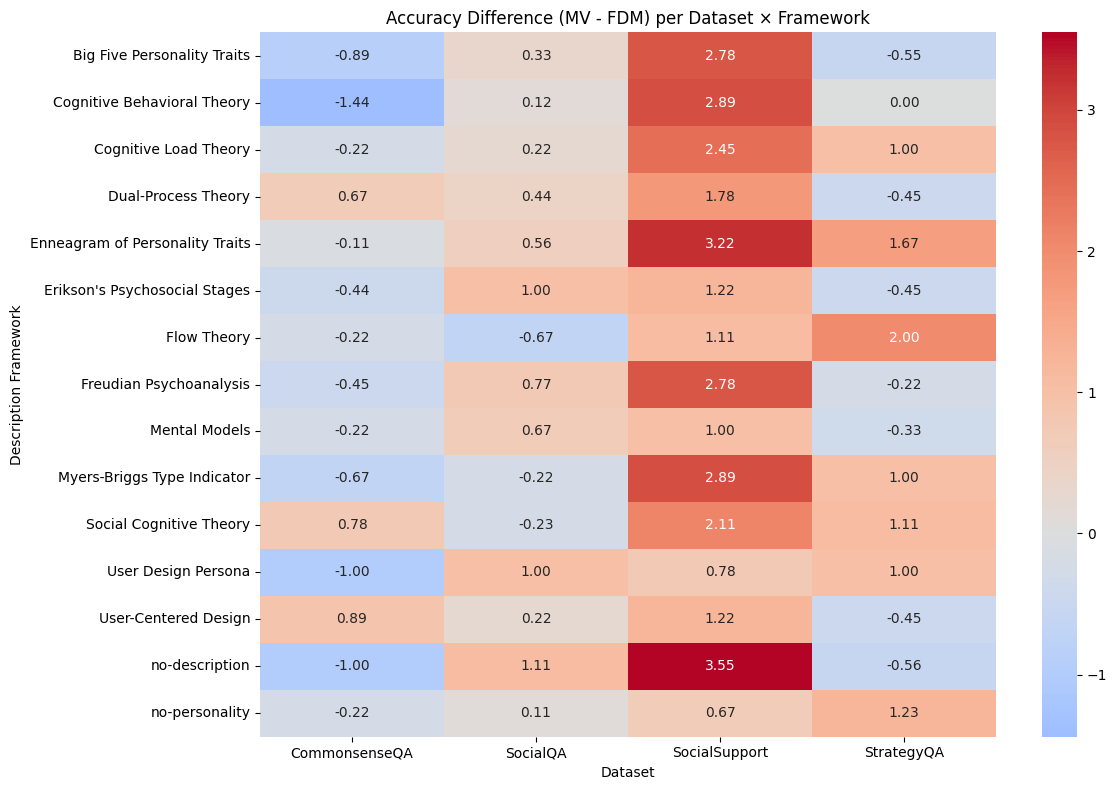

/tmp/ipykernel_73850/1325120124.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bar_data = df_summary.groupby("dataset").apply(


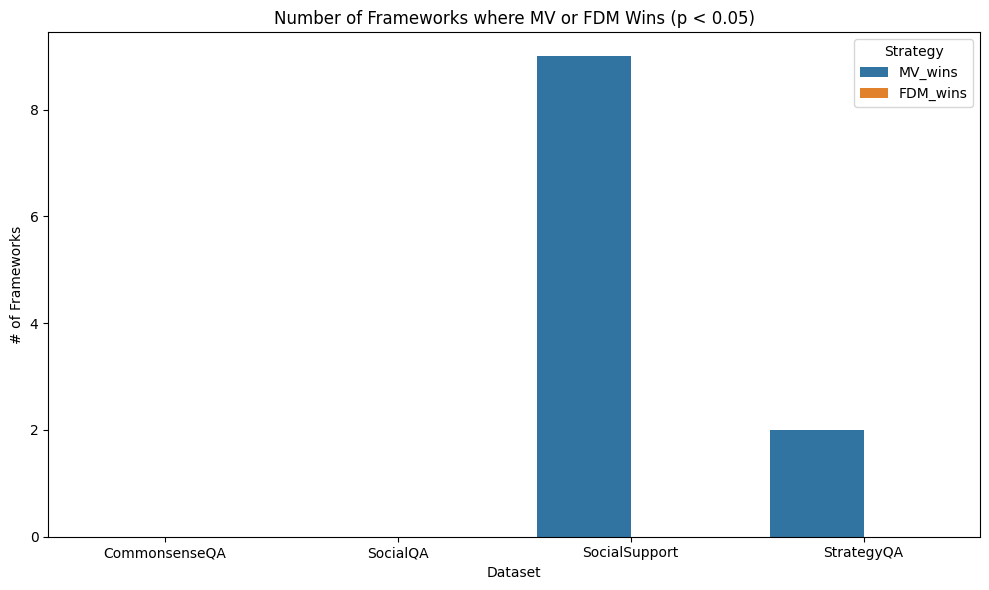

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate framework-level results per dataset
df_dataset_summary = df_summary.groupby("dataset").agg(
    avg_acc_mv=("acc_mv", "mean"),
    avg_acc_fdm=("acc_fdm", "mean"),
    n_frameworks_mv_better=("p_value", lambda x: ((df_summary.loc[x.index, "acc_mv"] > df_summary.loc[x.index, "acc_fdm"]) & (x < 0.05)).sum()),
    n_frameworks_fdm_better=("p_value", lambda x: ((df_summary.loc[x.index, "acc_fdm"] > df_summary.loc[x.index, "acc_mv"]) & (x < 0.05)).sum())
).reset_index()

print("===== Dataset-level aggregated results =====")
print(df_dataset_summary)

# 2. Compute net wins per framework
df_summary["net_wins"] = df_summary["n_mv→fdm"] - df_summary["n_fdm→mv"]

print("\n===== Net wins per framework =====")
print(df_summary[["dataset", "desc_framework", "net_wins"]])

# 3. Heatmap: acc_mv - acc_fdm per dataset × framework
# 3. Heatmap: acc_mv - acc_fdm per dataset × framework
heatmap_data = df_summary.pivot(index="desc_framework", columns="dataset", values="acc_mv") - \
               df_summary.pivot(index="desc_framework", columns="dataset", values="acc_fdm")

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Accuracy Difference (MV - FDM) per Dataset × Framework")
plt.ylabel("Description Framework")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()

# 4. Bar chart: #frameworks where MV wins vs FDM (p < 0.05)
bar_data = df_summary.groupby("dataset").apply(
    lambda x: pd.Series({
        "MV_wins": ((x["acc_mv"] > x["acc_fdm"]) & (x["p_value"] < 0.05)).sum(),
        "FDM_wins": ((x["acc_fdm"] > x["acc_mv"]) & (x["p_value"] < 0.05)).sum()
    })
).reset_index()

bar_data_melt = bar_data.melt(id_vars="dataset", value_vars=["MV_wins", "FDM_wins"],
                              var_name="Strategy", value_name="Num_Frameworks")

plt.figure(figsize=(10,6))
sns.barplot(data=bar_data_melt, x="dataset", y="Num_Frameworks", hue="Strategy")
plt.title("Number of Frameworks where MV or FDM Wins (p < 0.05)")
plt.ylabel("# of Frameworks")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# -----------------------------
# 1. Load PoE datasets
# -----------------------------
df_fdm = pd.read_csv('data/results_fdm.csv')
df_majorities = pd.read_csv('data/results_majorities.csv')

# Exclude frameworks with data collection errors
bad_frameworks = ["Big Five Personality Traits", "Cognitive Behavioral Theory"]

df_majorities = df_majorities[
    ~df_majorities["desc_framework"].isin(bad_frameworks)
]
df_fdm = df_fdm[
    ~df_fdm["desc_framework"].isin(bad_frameworks)
]

# -----------------------------
# 2. Compute correctness
# -----------------------------
df_fdm["is_correct"] = (
    df_fdm["final_answer_norm"].astype(str)
    == df_fdm["golden_answer_norm"].astype(str)
)

df_majorities["is_correct"] = (
    df_majorities["majority_rand"].astype(str)
    == df_majorities["golden_answer_norm"].astype(str)
)

# -----------------------------
# 3. Merge MV and FDM at query level
# -----------------------------
df_pair = pd.merge(
    df_majorities,
    df_fdm,
    on=["dataset", "desc_framework", "query_idx", "model"],
    suffixes=("_mv", "_fdm")
)

# -----------------------------
# 4. McNemar tests per dataset × model
#    (aggregating across frameworks)
# -----------------------------
results = []

for (dataset, model), df_d in df_pair.groupby(["dataset", "model"]):
    mv = df_d["is_correct_mv"]
    fdm = df_d["is_correct_fdm"]

    n_mv_to_fdm = ((mv == 1) & (fdm == 0)).sum()  # MV correct, FDM wrong
    n_fdm_to_mv = ((mv == 0) & (fdm == 1)).sum()  # FDM correct, MV wrong

    table = [[0, n_mv_to_fdm],
             [n_fdm_to_mv, 0]]

    # McNemar exact test
    test = mcnemar(table, exact=True)

    results.append({
        "dataset": dataset,
        "model": model,
        "n_mv→fdm": n_mv_to_fdm,
        "n_fdm→mv": n_fdm_to_mv,
        "p_value": test.pvalue
    })

df_mcnemar = pd.DataFrame(results)

# -----------------------------
# 5. Accuracy per dataset × model
# -----------------------------
df_accuracy = (
    df_pair
    .groupby(["dataset", "model"])
    .agg(
        acc_mv=("is_correct_mv", "mean"),
        acc_fdm=("is_correct_fdm", "mean")
    )
    .reset_index()
)

# Convert to percentages
df_accuracy["acc_mv"] = (df_accuracy["acc_mv"] * 100).round(2)
df_accuracy["acc_fdm"] = (df_accuracy["acc_fdm"] * 100).round(2)

# -----------------------------
# 6. Merge accuracy + McNemar
# -----------------------------
df_summary = pd.merge(
    df_accuracy,
    df_mcnemar,
    on=["dataset", "model"]
)

# -----------------------------
# 7. Print summary
# -----------------------------
print(df_summary[[
    "dataset",
    "model",
    "acc_mv",
    "acc_fdm",
    "n_mv→fdm",
    "n_fdm→mv",
    "p_value"
]])


          dataset                   model  acc_mv  acc_fdm  n_mv→fdm  \
0   CommonsenseQA          gemma-3-12b-it   84.85    85.77        26   
1   CommonsenseQA          gemma-3-27b-it   86.69    86.46        12   
2   CommonsenseQA           gemma-3-4b-it   72.23    71.92        36   
3   CommonsenseQA   llama-3.1-8b-instruct   75.85    77.69        34   
4   CommonsenseQA   llama-3.2-3b-instruct   63.62    61.54        73   
5   CommonsenseQA  llama-3.3-70b-instruct   87.46    88.15         7   
6   CommonsenseQA           llama-4-scout   86.15    87.00         8   
7   CommonsenseQA            mistral-nemo   78.85    78.31        37   
8   CommonsenseQA           nova-micro-v1   86.62    87.00        13   
9        SocialQA          gemma-3-12b-it   76.54    75.77        17   
10       SocialQA          gemma-3-27b-it   75.15    75.00        20   
11       SocialQA           gemma-3-4b-it   66.23    63.46        60   
12       SocialQA   llama-3.1-8b-instruct   73.54    72.46      

===== Dataset-level aggregated results (by model) =====
         dataset  avg_acc_mv  avg_acc_fdm  n_models_mv_better  \
0  CommonsenseQA   80.257778    80.426667                   1   
1       SocialQA   74.657778    74.274444                   1   
2  SocialSupport   46.052222    44.145556                   5   
3     StrategyQA   71.615556    71.112222                   2   

   n_models_fdm_better  
0                    1  
1                    1  
2                    1  
3                    0  

===== Net wins per model =====
          dataset                   model  net_wins
0   CommonsenseQA          gemma-3-12b-it       -12
1   CommonsenseQA          gemma-3-27b-it         3
2   CommonsenseQA           gemma-3-4b-it         4
3   CommonsenseQA   llama-3.1-8b-instruct       -24
4   CommonsenseQA   llama-3.2-3b-instruct        27
5   CommonsenseQA  llama-3.3-70b-instruct        -9
6   CommonsenseQA           llama-4-scout       -11
7   CommonsenseQA            mistral-nemo    

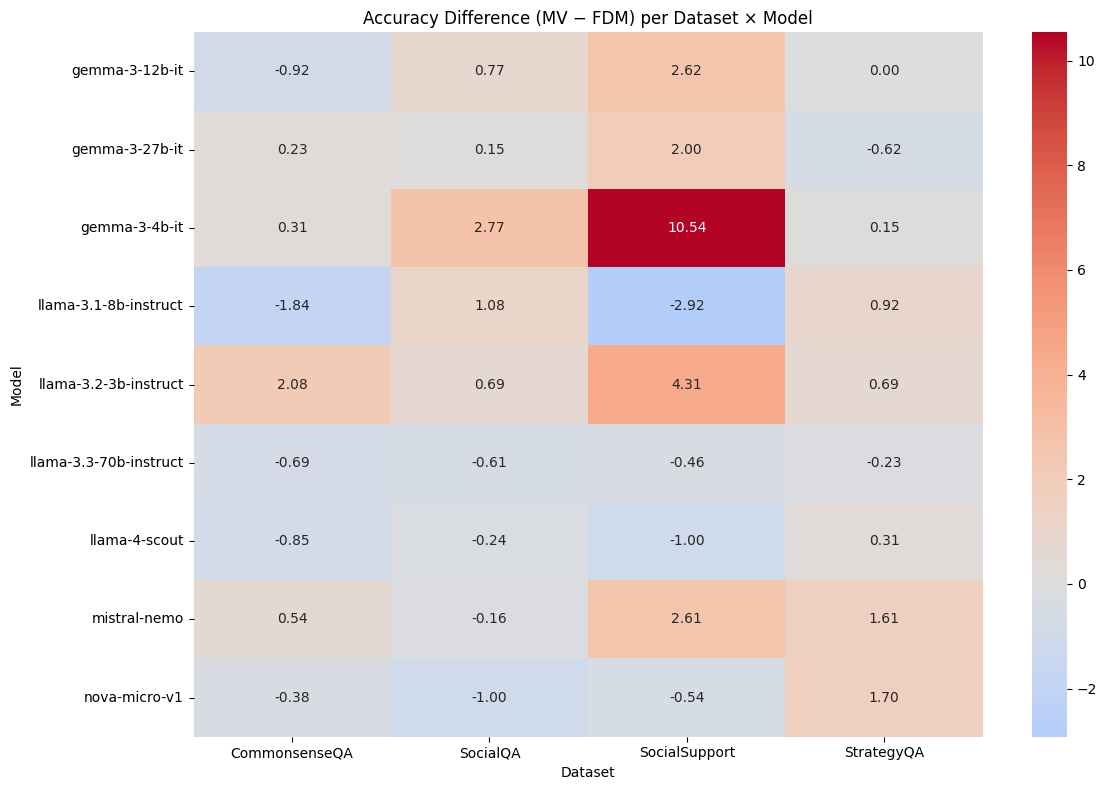

/tmp/ipykernel_73850/266579090.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


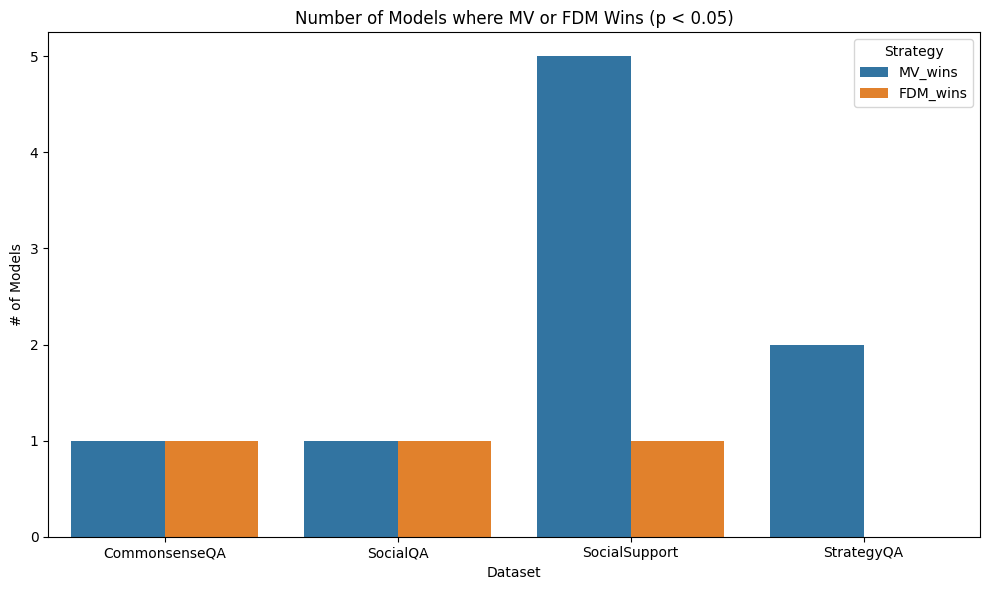

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate model-level results per dataset
df_dataset_summary = df_summary.groupby("dataset").agg(
    avg_acc_mv=("acc_mv", "mean"),
    avg_acc_fdm=("acc_fdm", "mean"),
    n_models_mv_better=(
        "p_value",
        lambda x: (
            (df_summary.loc[x.index, "acc_mv"] >
             df_summary.loc[x.index, "acc_fdm"]) & (x < 0.05)
        ).sum()
    ),
    n_models_fdm_better=(
        "p_value",
        lambda x: (
            (df_summary.loc[x.index, "acc_fdm"] >
             df_summary.loc[x.index, "acc_mv"]) & (x < 0.05)
        ).sum()
    )
).reset_index()

print("===== Dataset-level aggregated results (by model) =====")
print(df_dataset_summary)

# 2. Compute net wins per model
df_summary["net_wins"] = df_summary["n_mv→fdm"] - df_summary["n_fdm→mv"]

print("\n===== Net wins per model =====")
print(df_summary[["dataset", "model", "net_wins"]])

# 3. Heatmap: acc_mv - acc_fdm per dataset × model
heatmap_data = (
    df_summary.pivot(index="model", columns="dataset", values="acc_mv") -
    df_summary.pivot(index="model", columns="dataset", values="acc_fdm")
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Accuracy Difference (MV − FDM) per Dataset × Model")
plt.ylabel("Model")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()

# 4. Bar chart: #models where MV wins vs FDM (p < 0.05)
bar_data = (
    df_summary
    .groupby("dataset")
    .apply(
        lambda x: pd.Series({
            "MV_wins": ((x["acc_mv"] > x["acc_fdm"]) & (x["p_value"] < 0.05)).sum(),
            "FDM_wins": ((x["acc_fdm"] > x["acc_mv"]) & (x["p_value"] < 0.05)).sum()
        })
    )
    .reset_index()
)

bar_data_melt = bar_data.melt(
    id_vars="dataset",
    value_vars=["MV_wins", "FDM_wins"],
    var_name="Strategy",
    value_name="Num_Models"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=bar_data_melt,
    x="dataset",
    y="Num_Models",
    hue="Strategy"
)
plt.title("Number of Models where MV or FDM Wins (p < 0.05)")
plt.ylabel("# of Models")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# -----------------------------
# 1. Load datasets
# -----------------------------
df_fdm = pd.read_csv('data/results_fdm.csv')
df_majorities = pd.read_csv('data/results_majorities.csv')

# Exclude problematic frameworks
bad_frameworks = ["Big Five Personality Traits", "Cognitive Behavioral Theory"]
df_fdm = df_fdm[~df_fdm["desc_framework"].isin(bad_frameworks)]
df_majorities = df_majorities[~df_majorities["desc_framework"].isin(bad_frameworks)]

# -----------------------------
# 2. Compute correctness
# -----------------------------
df_fdm["is_correct"] = (
    df_fdm["final_answer_norm"].astype(str)
    == df_fdm["golden_answer_norm"].astype(str)
)

df_majorities["is_correct"] = (
    df_majorities["majority_rand"].astype(str)
    == df_majorities["golden_answer_norm"].astype(str)
)

# -----------------------------
# 3. Merge MV and FDM
# -----------------------------
df_pair = pd.merge(
    df_majorities,
    df_fdm,
    on=["dataset", "desc_framework", "query_idx", "model"],
    suffixes=("_mv", "_fdm")
)

# -----------------------------
# 4. McNemar per model × framework
#    (aggregated across datasets)
# -----------------------------
results = []

for (model, framework), df_d in df_pair.groupby(["model", "desc_framework"]):
    mv = df_d["is_correct_mv"]
    fdm = df_d["is_correct_fdm"]

    n_mv_to_fdm = ((mv == 1) & (fdm == 0)).sum()
    n_fdm_to_mv = ((mv == 0) & (fdm == 1)).sum()

    table = [[0, n_mv_to_fdm],
             [n_fdm_to_mv, 0]]

    test = mcnemar(table, exact=True)

    results.append({
        "model": model,
        "desc_framework": framework,
        "n_mv→fdm": n_mv_to_fdm,
        "n_fdm→mv": n_fdm_to_mv,
        "p_value": test.pvalue
    })

df_mcnemar = pd.DataFrame(results)

# -----------------------------
# 5. Accuracy per model × framework
# -----------------------------
df_accuracy = (
    df_pair
    .groupby(["model", "desc_framework"])
    .agg(
        acc_mv=("is_correct_mv", "mean"),
        acc_fdm=("is_correct_fdm", "mean")
    )
    .reset_index()
)

df_accuracy["acc_mv"] = (df_accuracy["acc_mv"] * 100).round(2)
df_accuracy["acc_fdm"] = (df_accuracy["acc_fdm"] * 100).round(2)

# -----------------------------
# 6. Merge summary
# -----------------------------
df_summary = pd.merge(
    df_accuracy,
    df_mcnemar,
    on=["model", "desc_framework"]
)

print(df_summary)


                      model                   desc_framework  acc_mv  acc_fdm  \
0            gemma-3-12b-it            Cognitive Load Theory   70.50    69.25   
1            gemma-3-12b-it              Dual-Process Theory   71.25    70.00   
2            gemma-3-12b-it  Enneagram of Personality Traits   69.50    69.00   
3            gemma-3-12b-it    Erikson's Psychosocial Stages   70.00    71.25   
4            gemma-3-12b-it                      Flow Theory   69.75    68.50   
5            gemma-3-12b-it          Freudian Psychoanalysis   69.75    68.50   
6            gemma-3-12b-it                    Mental Models   70.50    69.50   
7            gemma-3-12b-it      Myers-Briggs Type Indicator   70.50    70.25   
8            gemma-3-12b-it          Social Cognitive Theory   72.00    70.25   
9            gemma-3-12b-it              User Design Persona   70.25    69.75   
10           gemma-3-12b-it             User-Centered Design   71.00    71.00   
11           gemma-3-12b-it 

===== Model-level aggregated results =====
                    model  avg_acc_mv  avg_acc_fdm  n_frameworks_mv_better  \
0          gemma-3-12b-it   70.500000    69.884615                       0   
1          gemma-3-27b-it   71.711538    71.269231                       1   
2           gemma-3-4b-it   64.307692    60.865385                       7   
3   llama-3.1-8b-instruct   64.865385    65.557692                       0   
4   llama-3.2-3b-instruct   58.615385    56.673077                       2   
5  llama-3.3-70b-instruct   71.826923    72.326923                       0   
6           llama-4-scout   69.634615    70.076923                       0   
7            mistral-nemo   67.019231    65.865385                       1   
8           nova-micro-v1   74.826923    74.884615                       0   

   n_frameworks_fdm_better  
0                        0  
1                        1  
2                        0  
3                        0  
4                        0  
5 

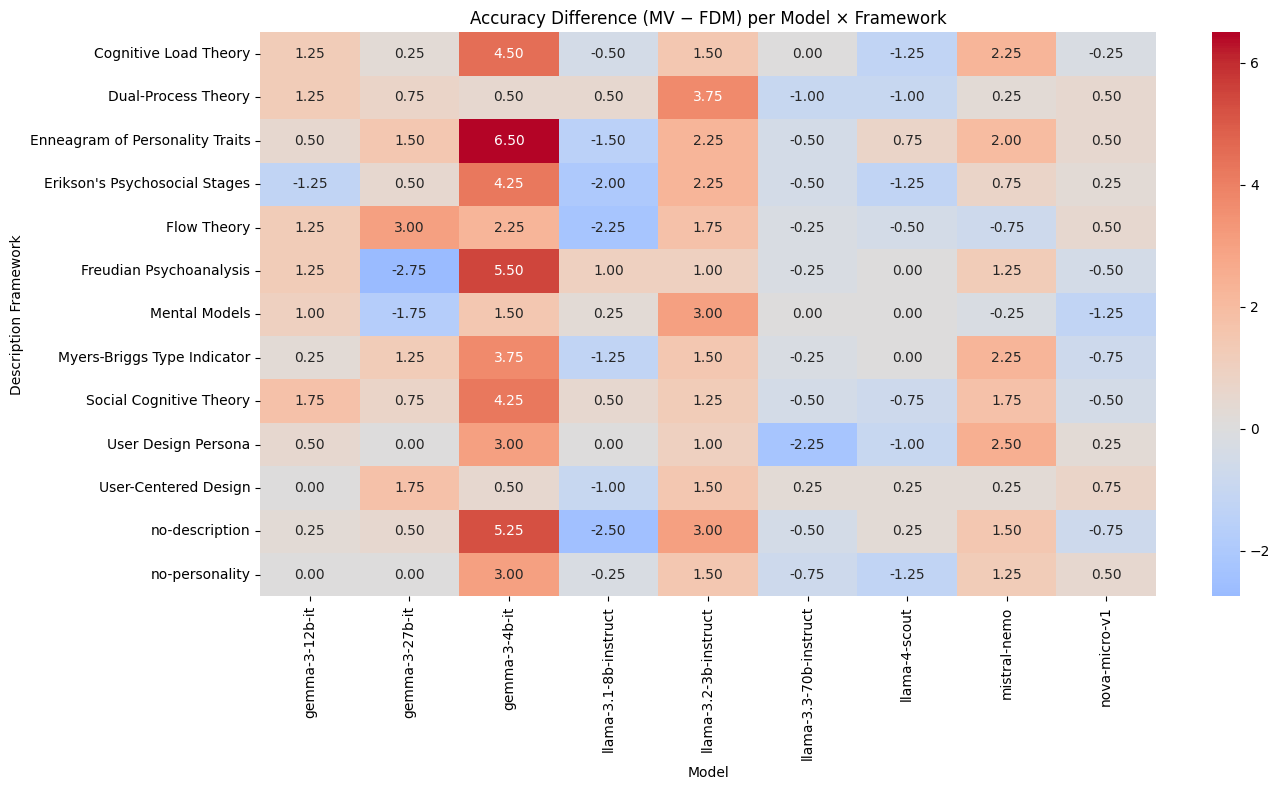

/tmp/ipykernel_73850/1981137821.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


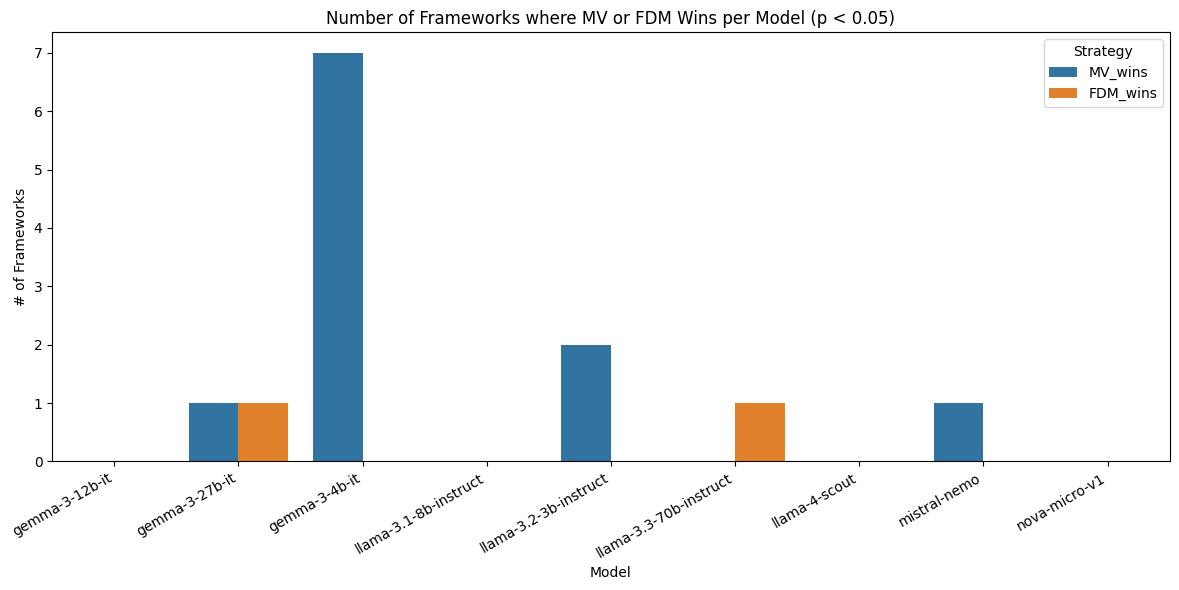

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate framework-level results per model
df_model_summary = df_summary.groupby("model").agg(
    avg_acc_mv=("acc_mv", "mean"),
    avg_acc_fdm=("acc_fdm", "mean"),
    n_frameworks_mv_better=(
        "p_value",
        lambda x: (
            (df_summary.loc[x.index, "acc_mv"] >
             df_summary.loc[x.index, "acc_fdm"]) & (x < 0.05)
        ).sum()
    ),
    n_frameworks_fdm_better=(
        "p_value",
        lambda x: (
            (df_summary.loc[x.index, "acc_fdm"] >
             df_summary.loc[x.index, "acc_mv"]) & (x < 0.05)
        ).sum()
    )
).reset_index()

print("===== Model-level aggregated results =====")
print(df_model_summary)

# 2. Net wins per model × framework
df_summary["net_wins"] = df_summary["n_mv→fdm"] - df_summary["n_fdm→mv"]

print("\n===== Net wins per model × framework =====")
print(df_summary[["model", "desc_framework", "net_wins"]])

# 3. Heatmap: acc_mv − acc_fdm per model × framework
heatmap_data = (
    df_summary.pivot(index="desc_framework", columns="model", values="acc_mv") -
    df_summary.pivot(index="desc_framework", columns="model", values="acc_fdm")
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Accuracy Difference (MV − FDM) per Model × Framework")
plt.ylabel("Description Framework")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# 4. Bar chart: #frameworks where MV vs FDM wins per model (p < 0.05)
bar_data = (
    df_summary
    .groupby("model")
    .apply(
        lambda x: pd.Series({
            "MV_wins": ((x["acc_mv"] > x["acc_fdm"]) & (x["p_value"] < 0.05)).sum(),
            "FDM_wins": ((x["acc_fdm"] > x["acc_mv"]) & (x["p_value"] < 0.05)).sum()
        })
    )
    .reset_index()
)

bar_data_melt = bar_data.melt(
    id_vars="model",
    value_vars=["MV_wins", "FDM_wins"],
    var_name="Strategy",
    value_name="Num_Frameworks"
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=bar_data_melt,
    x="model",
    y="Num_Frameworks",
    hue="Strategy"
)
plt.title("Number of Frameworks where MV or FDM Wins per Model (p < 0.05)")
plt.ylabel("# of Frameworks")
plt.xlabel("Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
